### Paridade de Juros: Dólar Futuro com DI base 252 e Cupom Cambial base 365
- **DI**: taxa de juros em reais, anualizada **compostamente**, com base em **252 dias úteis**.
- **Cupom cambial**: taxa de juros em dólares, anualizada **linearmente**, com base em **365 dias corridos**.

A base **252** é usada para ativos financeiros locais (como CDI, DI1). A base **365** é usada para mercados internacionais (dólar, Treasuries). Essa diferença de base exige cuidado para comparações corretas. A precificação teórica do dólar futuro é dada por:
$$
\text{Dólar Futuro} = \text{Dólar Spot} \times \frac{(1 + \text{DI})^{\frac{du}{252}}}{1 + \text{Cupom} \cdot \frac{dc}{365}}
$$
onde:
- `Dólar Spot`: cotação à vista (spot) do dólar em R$.
- `DI`: taxa de juros local (Brasil), composta, base 252.
- `Cupom`: cupom cambial (equivalente à taxa de juros implícita em dólar), linear, base 365.
- `du`: número de dias úteis entre a data de hoje e a data de vencimento.
- `dc`: número de dias corridos entre a data de hoje e a data de vencimento.

O **numerador** da fórmula representa o valor futuro de 1 real aplicado à taxa **DI** composta.
O **denominador** representa o valor futuro do dólar convertido de volta a reais usando uma taxa **linear**.
O quociente expressa a relação de arbitragem entre as moedas e define o valor justo do contrato futuro de dólar.

#### Aplicações
- Construção da régua de arbitragem (spot x futuro)
- Cálculo do cupom cambial implícito
- Avaliação de distorções de mercado e oportunidades de arbitragem


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from io import StringIO
from datetime import datetime, timedelta, date

import time

from selenium import webdriver
from selenium.webdriver.common.by import By

# Calcula datas de vencimento
def vencimento_b3(codigo):
    letras = {'F':1,'G':2,'H':3,'J':4,'K':5,'M':6,
              'N':7,'Q':8,'U':9,'V':10,'X':11,'Z':12}
    letra, ano = codigo[0], int("20" + codigo[1:])
    mes = letras[letra]
    # 1ª quarta-feira do mês
    for dia in range(1,8):
        d = datetime(ano, mes, dia)
        if d.weekday() == 2:  # quarta
            return d

feriados = pd.read_csv('data/feriados.csv', header=None)[0].values[1:].tolist() 

### DI
- **Contrato padrão:** R$ 100.000,00 na data de vencimento, e o valor na data de negociação (PU) é igual ao valor de R$100.000 descontado pela taxa negociada. 
- **Cotação:** Representa taxa de juros anual implícita no vencimento.
- **Relação preço × taxa:** Quanto maior a taxa de juros esperada, menor o preço do contrato.

##### Tabela de DI Futuro
Tabela  do mercado futuro de DI de 1 dia (Depósito Interfinanceiro) negociado na B3.  O Contrato Futuro de DI1 tem como ativo subjacente a taxa média diária dos Depósitos Interfinanceiros (DI), calculada e divulgada pela B3, compreendida entre a data de negociação, inclusive, e a data de vencimento, exclusive, e é utilizado para proteção e gerenciamento de risco de taxa de juro de ativos/passivos referenciados em DI. Usada por gestores de fundos, traders e analistas para: Monitorar a expectativa da curva de juros; fazer operações de hedge; avaliar tendências na política monetária.

**Colunas da tabela de DI Futuro**

| Coluna                   | Descrição |
|--------------------------|-----------|
| **AJUSTE ANTER. (3)**     | Preço de ajuste do contrato no dia anterior. Serve para apuração de ganhos/perdas dos participantes do mercado. |
| **AJUSTE CORRIG. (4)**    | Preço de ajuste do dia anterior corrigido por ajustes técnicos e financeiros, como alterações metodológicas. |
| **PREÇO ABERT.**          | Preço da primeira negociação do contrato no pregão do dia. |
| **PREÇO MÍN.**            | Menor preço negociado ao longo do dia. |
| **PREÇO MÁX.**            | Maior preço negociado ao longo do dia. |
| **PREÇO MÉD.**            | Média ponderada dos preços das negociações do dia. |
| **ÚLT. PREÇO**            | Último preço negociado antes do fechamento do pregão. |
| **AJUSTE**                | Preço de ajuste oficial do dia, utilizado para liquidação financeira dos contratos. |
| **VAR. PTOS.**            | Variação em pontos-base em relação ao ajuste anterior. Valores com "+" indicam alta, "-" indicam queda. |
| **ÚLT. OF. COMPRA**       | Última taxa ofertada por compradores do contrato. |
| **ÚLT. OF. VENDA**        | Última taxa ofertada por vendedores do contrato. |

---


In [2]:
# data de ontem
data_base = (date.today() - timedelta(days=1)).strftime('%d/%m/%Y')  # '12/07/2023'

In [3]:
driver = webdriver.Chrome() 

url = f'''https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?
pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={data_base}
&Mercadoria=DI1'''

driver.get(url)

## tabela de contratos futuros de DI
path_tabela = '/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[3]/table'
elemento = driver.find_element(By.XPATH, path_tabela)
html_tabela = elemento.get_attribute('outerHTML')
tabela = pd.read_html(StringIO(html_tabela))[0]
tabela = tabela.drop(tabela.columns[[0, 1, 2, 3, 4, 8, 9, 10]], axis=1)
tabela.columns = tabela.iloc[0]
tabela = tabela.iloc[1:].reset_index(drop=True) 
tabela['PU'] = tabela['AJUSTE'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
tabela = tabela.drop(tabela.columns[[ 2]], axis=1)
tabela.columns = ['tx DI med' , 'tx DI' , 'PU']
tabela[['tx DI med' , 'tx DI' ]] = tabela[['tx DI med' , 'tx DI' ]].astype(float)/100000  

path_indice = '/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[1]/table'        
elemento_indice = driver.find_element(By.XPATH, path_indice)
html_indice = elemento_indice.get_attribute('outerHTML')
indice = pd.read_html(StringIO(html_indice))[0].values.flatten().tolist()
codigos = indice[1:]

tabela['codigos']= codigos

feriados_formatados = [datetime.strptime(f, '%d/%m/%Y').strftime('%Y-%m-%d') for f in feriados]
# data_base_formatada = data_base.strftime('%Y-%m-%d')
cal = np.busdaycalendar(holidays=feriados_formatados)
tabela['Vencimento'] = tabela['codigos'].map(vencimento_b3)


tabela['DU'] = tabela['Vencimento'].dt.strftime('%Y-%m-%d').map(
    lambda d: np.busday_count(
        datetime.strptime(data_base, '%d/%m/%Y').strftime('%Y-%m-%d'),
        d,
        busdaycal=cal
    )
)

tabela['DI implicito para PU'] = (100000 / tabela['PU']) ** (252 / tabela['DU']) - 1
tabela_di=tabela[['Vencimento','codigos', 'tx DI med', 'tx DI', 'PU',  'DU', 'DI implicito para PU']].copy()
tabela_di			

,Vencimento,codigos,tx DI med,tx DI,PU,DU,DI implicito para PU
0,2025-07-02,N25,0.14899,0.14898,99889.83,3,0.097016
1,2025-08-06,Q25,0.14904,0.14906,98631.21,28,0.132063
2,2025-09-03,U25,0.14924,0.14925,97492.67,48,0.142608
3,2025-10-01,V25,0.14932,0.14935,96313.57,68,0.149350
4,2025-11-05,X25,0.14935,0.14940,95097.70,93,0.145915
5,2025-12-03,Z25,0.14930,0.14940,94104.87,113,0.145110
6,2026-01-07,F26,0.14928,0.14935,92969.91,136,0.144616
7,2026-02-04,G26,0.14912,0.14920,91899.44,156,0.146209
8,2026-03-04,H26,0.14910,0.14910,90999.78,174,0.146360
9,2026-04-01,J26,0.14867,0.14885,89920.85,194,0.147979


In [4]:
driver.close()

In [5]:
tabela_di=tabela[['Vencimento','codigos', 'tx DI med', 'tx DI', 'PU',  'DU', 'DI implicito para PU']].copy()
tabela_di			

,Vencimento,codigos,tx DI med,tx DI,PU,DU,DI implicito para PU
0,2025-07-02,N25,0.14899,0.14898,99889.83,3,0.097016
1,2025-08-06,Q25,0.14904,0.14906,98631.21,28,0.132063
2,2025-09-03,U25,0.14924,0.14925,97492.67,48,0.142608
3,2025-10-01,V25,0.14932,0.14935,96313.57,68,0.149350
4,2025-11-05,X25,0.14935,0.14940,95097.70,93,0.145915
5,2025-12-03,Z25,0.14930,0.14940,94104.87,113,0.145110
6,2026-01-07,F26,0.14928,0.14935,92969.91,136,0.144616
7,2026-02-04,G26,0.14912,0.14920,91899.44,156,0.146209
8,2026-03-04,H26,0.14910,0.14910,90999.78,174,0.146360
9,2026-04-01,J26,0.14867,0.14885,89920.85,194,0.147979


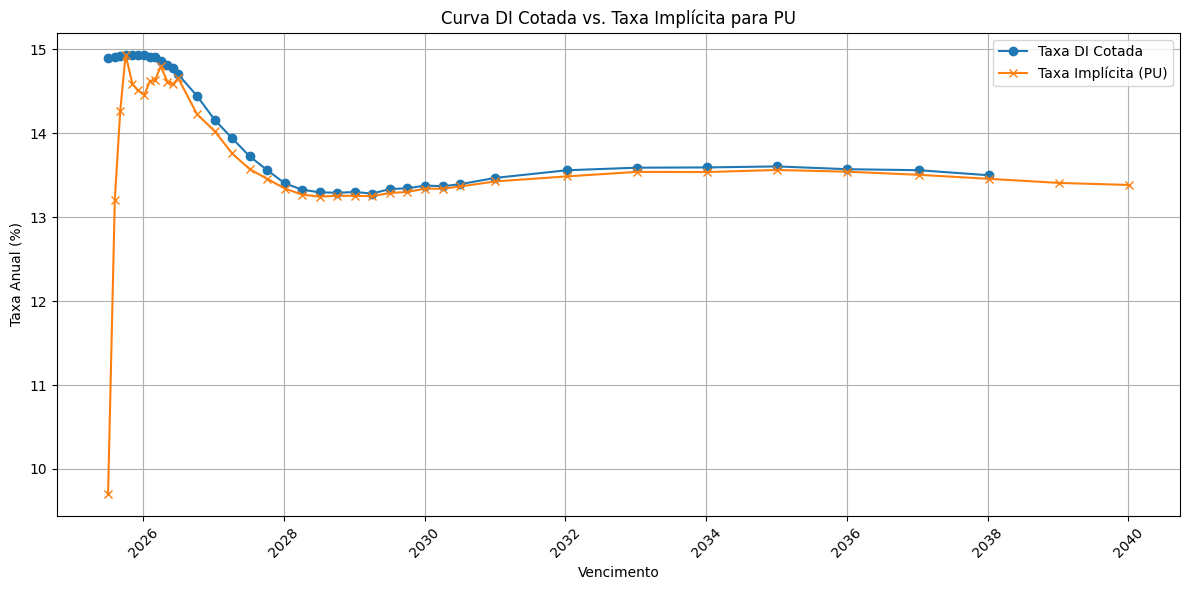

In [6]:
import matplotlib.pyplot as plt

# Garante ordenação por vencimento
tabela_di = tabela_di[tabela_di != 0].sort_values('Vencimento')

plt.figure(figsize=(12, 6))
plt.plot(tabela_di['Vencimento'], tabela_di['tx DI med'] * 100, label='Taxa DI Cotada', marker='o')
plt.plot(tabela_di['Vencimento'], tabela_di['DI implicito para PU'] * 100, label='Taxa Implícita (PU)', marker='x')

plt.xlabel('Vencimento')
plt.ylabel('Taxa Anual (%)')
plt.title('Curva DI Cotada vs. Taxa Implícita para PU')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Limite de alerta: 50 pontos-base 
limite_alerta = 0.0050

# Calcula o desvio
tabela_di['desvio'] = tabela_di['DI implicito para PU'] - tabela_di['tx DI med']
# Filtra desvios acima do limite
descolados = tabela_di[abs(tabela_di['desvio']) > limite_alerta]

# Exibe os alertas
if not descolados.empty:
    print("⚠️ Descolamento entre Taxa Cotada e Implícita:")
    display(descolados[['Vencimento', 'codigos', 'tx DI', 'DI implicito para PU', 'desvio']])
else:
    print("Nenhum descolamento relevante detectado.")


⚠️ Descolamento entre Taxa Cotada e Implícita:


,Vencimento,codigos,tx DI,DI implicito para PU,desvio
0,2025-07-02,N25,0.14898,0.097016,-0.051974
1,2025-08-06,Q25,0.14906,0.132063,-0.016977
2,2025-09-03,U25,0.14925,0.142608,-0.006632


### Cupom Cambial

O  cupom cambial ($\approx$ (1 + juro USD)/(1 + juro DI)-1) pode ser interpretado como o rendimento em dólares para estrangeiros que assumem o risco de investir no Brasil. 
Objeto de negociação é a taxa de juro (expressa em percentual ao ano, linear, base 360 dias corridos, com até três casas decimais) obtida a partir do cálculo da diferença entre a acumulação da Taxa de DI, no período compreendido entre a data de operação, inclusive, e a data de vencimento, exclusive, e a variação da taxa de câmbio PTAX800 venda observada entre o dia útil anterior à data da operação, inclusive, e a data de vencimento do contrato, exclusive.

Contrato padrão: US$50.000,00

No cupom cambial, o preço reflete o valor presente de US$ 50.000, descontado pela diferença entre o juro doméstico (DI) e o juro externo (Libor ou juro USD NDF) até o vencimento:
$$
\text{PU} = 100.000 × \left(\frac{1+r_{\text{US\$}}}{1+r_{\text{R\$}}}\right)^{\frac{DU}{252}}
$$
Dessa forma:
- Se o PU cai, o juro em reais está subindo (ou o juro em USD caindo).
- Se o PU sobe, o juro em reais está caindo em relação ao juro em dólar.

#### Tabela do DDI Futuro

| **Coluna**             | **Descrição**                                                                                                                             |
| ---------------------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| **AJUSTE ANTER. (3)**  | PU do dia anterior. Valor de ajuste do contrato no fechamento do **dia anterior**. Serve como referência de marcação a mercado para cálculo de variação.      |
| **AJUSTE CORRIG. (4)** | Ajuste anterior corrigido por eventos corporativos ou ajustes técnicos pela B3. Em muitos dias será igual ao ajuste anterior.             |
| **PREÇO ABERT.**       | Preço em taxa negociado na **abertura** do dia. Muitas vezes é a primeira operação do contrato.                                                   |
| **PREÇO MÍN.**         | **Menor preço** em taxa do contrato negociado no dia.                                                                                             |
| **PREÇO MÁX.**         | **Maior preço** do contrato no dia.                                                                                                       |
| **PREÇO MÉD.**         | **Média ponderada** em taxa dos preços negociados ao longo do dia. Quando há liquidez, é a **melhor proxy da taxa do mercado**.                   |
| **ÚLT. PREÇO**         | Último preço em taxa negociado no dia. Pode refletir movimentos finais do mercado.                                                                |
| **AJUSTE**             | Valor de ajuste do **dia atual**, calculado com base nos preços negociados. É utilizado na liquidação diária (ajuste diário de posições). |
| **VAR. PTOS.**         | Variação em pontos entre o ajuste anterior e o atual. Pode ter sinal negativo (“-”) ou positivo (“+”).                                    |
| **ÚLT. OF. COMPRA**    | Último valor **ofertado por compradores** (bid). Indica interesse de compra.                                                              |
| **ÚLT. OF. VENDA**     | Último valor **ofertado por vendedores** (ask). Indica interesse de venda.                                                                |


In [1]:
driver = webdriver.Chrome() 

url = f'''https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?
pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={data_base}
&Mercadoria=DDI'''

driver.get(url)

## tabela de contratos futuros de DI
path_tabela = '/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[3]/table'
elemento = driver.find_element(By.XPATH, path_tabela)
html_tabela = elemento.get_attribute('outerHTML')
tabela = pd.read_html(StringIO(html_tabela))[0]
tabela = tabela.drop(tabela.columns[[0, 1, 2, 3, 4, 8, 9, 10]], axis=1)
tabela.columns = tabela.iloc[0]
tabela = tabela.iloc[1:].reset_index(drop=True) 
tabela['PU'] = tabela['AJUSTE'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
tabela = tabela.drop(tabela.columns[[ 2]], axis=1)
tabela.columns = ['tx DI med' , 'tx DDI' , 'PU']
tabela[['tx DI med' , 'tx DDI' ]] = tabela[['tx DI med' , 'tx DDI' ]].astype(float)/100000  

path_indice = '/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[1]/table'        
elemento_indice = driver.find_element(By.XPATH, path_indice)
html_indice = elemento_indice.get_attribute('outerHTML')
indice = pd.read_html(StringIO(html_indice))[0].values.flatten().tolist()
codigos = indice[1:]

tabela['codigos']= codigos

feriados_formatados = [datetime.strptime(f, '%d/%m/%Y').strftime('%Y-%m-%d') for f in feriados]
# data_base_formatada = data_base.strftime('%Y-%m-%d')
cal = np.busdaycalendar(holidays=feriados_formatados)
tabela['Vencimento'] = tabela['codigos'].map(vencimento_b3)


tabela['DU'] = tabela['Vencimento'].dt.strftime('%Y-%m-%d').map(
    lambda d: np.busday_count(
        datetime.strptime(data_base, '%d/%m/%Y').strftime('%Y-%m-%d'),
        d,
        busdaycal=cal
    )
)

tabela['tx ddi implicita']= (100000 / tabela['PU']) ** (252 / tabela['DU']) - 1

tabela_ddi=tabela[['Vencimento','codigos', 'tx DI med', 'tx DDI','tx ddi implicita', 'PU',  'DU']].copy()
tabela_ddi			

NameError: name 'webdriver' is not defined

In [9]:
driver.close()

In [10]:
curva = pd.merge(tabela_ddi[['Vencimento', 'codigos', 'tx ddi implicita']], 
                 tabela_di[['Vencimento', 'tx DI med']], 
                 on='Vencimento', suffixes=('_ddi', '_di'))
curva['juros_usd_implicito'] = curva['tx DI med'] - curva['tx ddi implicita']
curva


,Vencimento,codigos,tx ddi implicita,tx DI med,juros_usd_implicito
0,2025-07-02,N25,0.617264,0.14899,-0.468274
1,2025-08-06,Q25,0.103161,0.14904,0.045879
2,2025-09-03,U25,0.080668,0.14924,0.068572
3,2025-10-01,V25,0.075125,0.14932,0.074195
4,2025-11-05,X25,0.067895,0.14935,0.081455
5,2025-12-03,Z25,0.064775,0.14930,0.084525
6,2026-01-07,F26,0.063119,0.14928,0.086161
7,2026-02-04,G26,0.061299,0.14912,0.087821
8,2026-03-04,H26,0.060352,0.14910,0.088748
9,2026-04-01,J26,0.059053,0.14867,0.089617


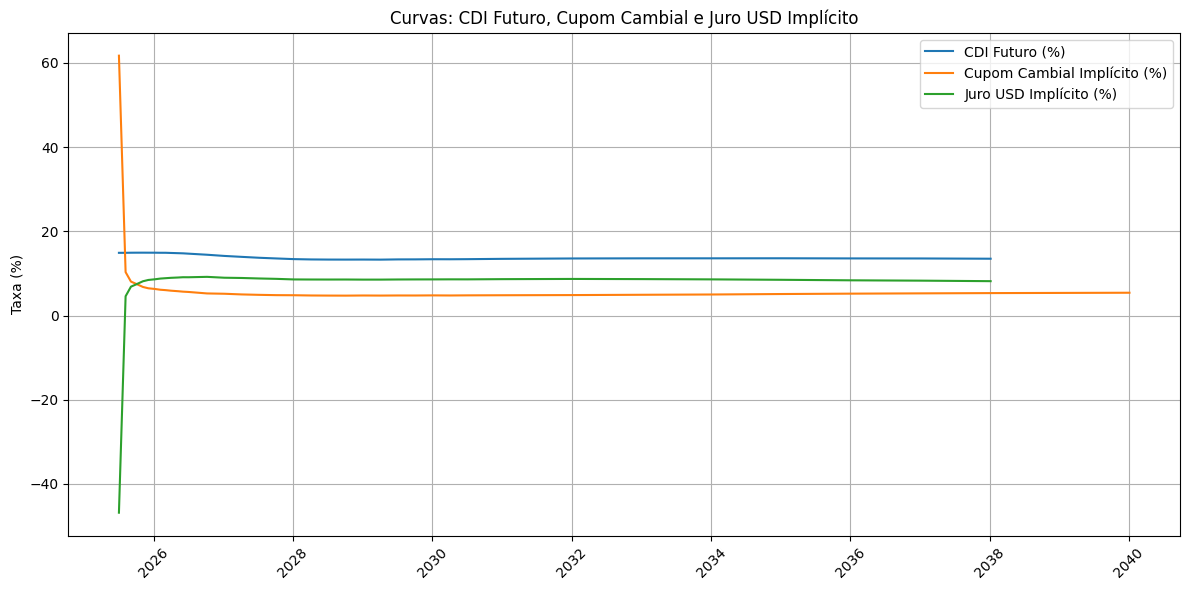

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(curva['Vencimento'], curva['tx DI med']*100, label='CDI Futuro (%)')
plt.plot(curva['Vencimento'], curva['tx ddi implicita']*100, label='Cupom Cambial Implícito (%)')
plt.plot(curva['Vencimento'], curva['juros_usd_implicito']*100, label='Juro USD Implícito (%)')

plt.xticks(rotation=45)
plt.ylabel('Taxa (%)')
plt.title('Curvas: CDI Futuro, Cupom Cambial e Juro USD Implícito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
